# [12] Segmentation 개론

본 실습에서는 Segmentation을 위해 구현한 `U-Net`, `Loss`를 활용하여서 신경망을 간단하게 학습하여 봅시다.

In [2]:
!pip install albumentations

     |████████████████████████████████| 117 kB 1.0 MB/s eta 0:00:01
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65162 sha256=3747f250974c18a3c964e6fdda7b604b40e85f096d7f3534f4d9ef1dd49cb9b1
  Stored in directory: /home/taehyeon/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations


하기 자료는 https://hoya012.github.io/blog/albumentation_tutorial/ 를 참고하여 만들었습니다.

### albumentations 

이 오픈 코드는 https://www.mdpi.com/2078-2489/11/2/125 라는 이름으로 저널에도 출판되었습니다.

이것은 처리 속도도 더 빠르고 기능도 다양하며 무엇보다 기존 torchvision.transforms으로 짜여진 코드를 대체하는 것도 5분이 채걸리지 않음.

가장 빠르다는 장점이 있습니다.

In [2]:
import torch
import torch.nn as nn
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
import torch.nn.functional as F
import torchvision
from albumentations import Compose,Resize,OneOf,RandomBrightness,RandomContrast,Normalize,HorizontalFlip,Blur,ElasticTransform,GridDistortion,OpticalDistortion,GaussNoise 
from albumentations.pytorch import ToTensor
import pandas as pd
import numpy as np
import nibabel as nib
from PIL import Image
import time
import matplotlib.pyplot as plt
import cv2
import copy
from tqdm import tqdm_notebook as tqdm

In [3]:
seed = 271
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Dataset의 구성

`torch.utils.data.Dataset` 은 데이터셋을 나타내는 추상클래스입니다. 

여러분의 데이터셋은 Dataset 에 상속하고 아래와 같이 오버라이드 해야합니다.

len(dataset)에서 호출되는 `__len__` 은 데이터셋의 크기를 리턴해야합니다.

`dataset[i]` 에서 호출되는 `__getitem__` 은 𝑖번째 샘플을 찾는데 사용됩니다.

이제 데이터셋 클래스를 만들어보도록 하겠습니다. `__init__` 을 사용해서 CSV 파일 안에 있는 데이터를 읽지만, `__getitem__` 을 이용해서 이미지의 판독을 합니다. 이 방법은 모든 이미지를 메모리에 저장하지 않고 필요할때마다 읽기 때문에 메모리를 효율적으로 사용합니다.

데이터셋의 샘플은 `{'image': image, 'landmarks': landmarks}` 의 사전 형태를 갖습니다.

In [4]:
class Covid19_CT_Dataset(torch.utils.data.Dataset):
    def __init__(self, cts_path, masks_path, transform=None, transform2=None):
        self.transforms = transform
        self.transforms2 = transform2
        self.cts_path = cts_path
        self.masks_path = masks_path
        self.len = np.array(nib.load(self.cts_path).get_fdata()).shape[-1]
        
    def __getitem__(self,index):
        ct = nib.load(self.cts_path)
        ct = np.rot90(np.array(ct.get_fdata()))
        image = ct[:,:,index]
        image = Image.fromarray(image)
        image = np.array(image.convert('RGB'))
        
        ct_mask = nib.load(self.masks_path)
        ct_mask = np.rot90(np.array(ct_mask.get_fdata()))
        mask = ct_mask[:,:,index]
        
        labels = np.unique(mask).astype("uint8")
        labels = labels[1:]
        target_mask = np.zeros((mask.shape[0], mask.shape[1], 3))
        for label in labels:
            target_mask[:,:, label-1 : label] = np.expand_dims(mask, -1)==label
        
        if self.transforms is not None:
            augument = self.transforms(image=image,mask=target_mask)
            image = augument['image']
            target_mask = augument['mask']
            
        if self.transforms2 is not None:
            image = self.transforms2(image=image)['image']
        
        target_mask = ToTensor()(image=target_mask)['image']
        
        image = ToTensor()(image=image)['image']
        
        return image, target_mask
    
    def __len__(self):
        return self.len

In [5]:
imgsize = 256
transforms = {
    'both': Compose([
                    Resize(imgsize,imgsize),
                    HorizontalFlip(p=0.5), 
                    OneOf([ElasticTransform(alpha=120, sigma=120*0.05, alpha_affine=120*0.03), GridDistortion(), OpticalDistortion(distort_limit=2, shift_limit=0.5)], p=0.3),
                    ]),
    
    'image': Compose([
                    OneOf([RandomBrightness(limit=0.1, p=0.4), RandomContrast(limit=0.1, p=0.4)]),
                    GaussNoise(),
                    Blur(p=0.1, blur_limit = 3),
                    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                    ]),
}

In [6]:
csv_file = './covid19-ct-scans/metadata.csv'
df = pd.read_csv(csv_file)
df = df.replace('../input/covid19-ct-scans/','./covid19-ct-scans/',regex=True)
cts_path = df['ct_scan'].tolist()
masks_path = df['lung_and_infection_mask'].tolist()
dataset = Covid19_CT_Dataset(cts_path[0],masks_path[0],transform=transforms['both'], transform2=None)

FileNotFoundError: [Errno 2] File ./covid19-ct-scans/metadata.csv does not exist: './covid19-ct-scans/metadata.csv'

- Red: 붉은 색은 왼쪽 폐
- Green: 초록 색은 오른쪽 폐
- Blue: Infection(감염) 지역

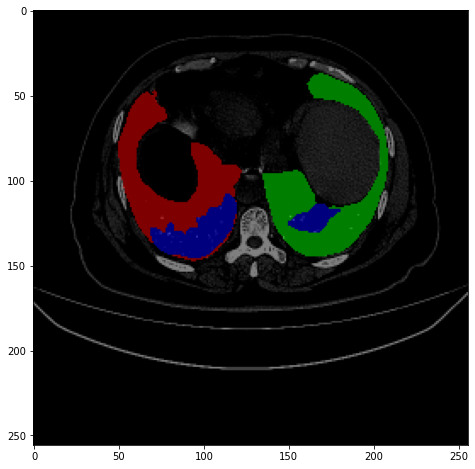

In [9]:
img_id = 100
plt.figure(figsize=(8,8))
plt.imshow(dataset[img_id][0].permute(1,2,0).numpy(), cmap='bone')
plt.imshow(dataset[img_id][1].permute(1,2,0).numpy(), alpha=0.5, cmap='Reds')

In [10]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        BCE = nn.BCELoss()(inputs, targets)
        num = targets.size(0)     
        inputs = inputs.reshape(num, -1)
        targets = targets.reshape(num, -1)
        
        intersection = (inputs * targets).sum(1) 
        dice = (2.*intersection + smooth)/(inputs.sum(1) + targets.sum(1) + smooth) 
        dice_loss = 1 - dice.sum()/num

        loss_final = 3*BCE + dice_loss
        return loss_final
    
    

class IoU(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoU, self).__init__()

    def forward(self, inputs, targets, smooth=1):
              
        
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return IoU * 100

    
    
class DiceScore(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceScore, self).__init__()

    def forward(self, inputs, targets, smooth=1):
              
        
        intersection = (inputs * targets).sum()                            
        dice_score = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth) 
        return dice_score
    

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = 1
        self.gamma = 2
        
    def forward(self, inputs, targets):
        num = targets.size(0)
        inputs = inputs.reshape(num, -1)
        targets = targets.reshape(num, -1)
        BCE_loss = F.binary_cross_entropy(inputs, targets, reduce=False)
        batch_loss = self.alpha * (1 - inputs) ** self.gamma * BCE_loss
        loss = batch_loss.mean()
        
        return loss

In [11]:
def compute_iou(model, loader, threshold=0.3):
    model.eval()
    valloss = 0
    
    with torch.no_grad():
        for data, target in loader:
            
            data = data.to(device)
            target = target.to(device)
            
            outputs = model(data)

            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < threshold)] = 0.0
            out_cut[np.nonzero(out_cut >= threshold)] = 1.0

            picloss = DiceScore()(out_cut, target.data.cpu().numpy())
            valloss += picloss

    return valloss /len(loader)

In [12]:
class ConvBlock(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size=(3,3),padding=1):
        super(ConvBlock,self).__init__()
        self.conv = nn.Conv2d(in_channels,out_channels,kernel_size,padding=padding)
        self.batchnorm = nn.BatchNorm2d(out_channels,eps=1e-4)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self,x):
        x = self.conv(x)
        x = self.batchnorm(x)
        x = self.relu(x)
        return x
        
        
class StackEncoder(nn.Module):
    def __init__(self,channel1,channel2,kernel_size=(3,3),padding=1):
        super(StackEncoder,self).__init__()
        self.maxpool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.block = nn.Sequential(
            ConvBlock(channel1,channel2,kernel_size,padding),
            ConvBlock(channel2,channel2,kernel_size,padding),     
        )
        
    def forward(self,x):
        copy_out = self.block(x)
        poolout = self.maxpool(copy_out)
        return copy_out,poolout
     
        
class StackDecoder(nn.Module):
    def __init__(self,copy_channel,channel1,channel2,kernel_size=(3,3),padding=1):
        super(StackDecoder,self).__init__()
        self.unConv = nn.ConvTranspose2d(channel1,channel1,kernel_size=(2,2),stride=2)
        self.block = nn.Sequential(
            ConvBlock(channel1+copy_channel,channel2,kernel_size,padding),
            ConvBlock(channel2,channel2,kernel_size,padding),
            ConvBlock(channel2,channel2,kernel_size,padding),
        )
        
    def forward(self,x,down_copy):
            _, channels, height, width = down_copy.size()  
            x = self.unConv(x)
            x = torch.cat([x, down_copy], 1)
            x = self.block(x)
            return x
        
        
class Unet(nn.Module):
    def __init__(self):
        super(Unet,self).__init__()
        
        self.down1 = StackEncoder(3,32,kernel_size=(3,3))             
        self.down2 = StackEncoder(32,64,kernel_size=(3,3))            
        self.down3 = StackEncoder(64,128,kernel_size=(3,3))           
        self.down4 = StackEncoder(128,256,kernel_size=(3,3))          
        
        self.center = ConvBlock(256,256,kernel_size=(3,3),padding=1)  
        
        self.up4 = StackDecoder(256,256,128,kernel_size=(3,3))        
        self.up3 = StackDecoder(128,128,64,kernel_size=(3,3))         
        self.up2 = StackDecoder(64,64,32,kernel_size=(3,3))           
        self.up1 = StackDecoder(32,32,16,kernel_size=(3,3))           
        self.conv = Conv2d(16,3,kernel_size=(1,1),bias=True)
        
    def forward(self,x):
        copy1,out = self.down1(x)  
        copy2,out = self.down2(out)  
        copy3,out = self.down3(out)
        copy4,out = self.down4(out)
        
        out = self.center(out)
        
        up4 = self.up4(out,copy4)
        up3 = self.up3(up4,copy3)
        up2 = self.up2(up3,copy2)
        up1 = self.up1(up2,copy1)
        
        out = self.conv(up1)
        out = nn.Sigmoid()(out)


        return out


In [22]:
def train(model, criterion, optimizer, lr_scheduler, num_epochs=20):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 100
    print_freq = int(len(dataloader['train'])/20)
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in ['train','val']:
            if phase == 'train':
                model.train() 
            else:
                model.eval() 

            running_loss = 0.0
            size = 0
            pb = tqdm(dataloader[phase], total=len(dataloader[phase]))
            for i, (images, masks) in enumerate(pb):
                images = images.to(device)
                masks = masks.to(device)

                optimizer.zero_grad()       

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(images)
                    loss = criterion[0](outputs, masks) + 4*criterion[1](outputs, masks)
                    loss = loss / accumulation_steps
                    if phase == 'train':
                        loss.backward()
                        if (i + 1 ) % accumulation_steps == 0:
                            optimizer.step()
                            lr_scheduler.step()

                running_loss += loss.item() * images.size(0)
                size += images.size(0)
                pb.set_postfix(loss=running_loss/size)
 
            epoch_loss = running_loss / dataset_size[phase]
            print()
            print('{} Loss: {:.4f}'.format(phase, epoch_loss))
            
            if phase == 'train':
                train_loss.append(epoch_loss)
                
            elif phase == 'val':
                iou = compute_iou(model, dataloader[phase], threshold=0.3)
                print("DICE score : ", iou)
                val_loss.append(epoch_loss)
                
                
            if phase == 'val' and epoch_loss <= best_loss:
                print('New Optimal Found!')
                best_loss = epoch_loss
                torch.save(model.state_dict(), 'segmantation.pth')

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print()
    
    model.load_state_dict(best_model_wts)
    return model

In [18]:
csv_file = r'./covid19-ct-scans/metadata.csv'
df = pd.read_csv(csv_file)
df = df.replace('../input/covid19-ct-scans/','./covid19-ct-scans/',regex=True)

cts_path = df['ct_scan'].tolist()
masks_path = df['lung_and_infection_mask'].tolist()
dataset_list = []
for i in range(20):
    dataset_list.append(Covid19_CT_Dataset(cts_path[i],masks_path[i],transform=transforms['both'], transform2=transforms['image']))
      
dataset_train = torch.utils.data.ConcatDataset(dataset_list[:16])
dataset_val = torch.utils.data.ConcatDataset(dataset_list[16:])


train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=8, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(dataset_val, batch_size=8, shuffle=False, num_workers=2)
dataset_size = {'train':len(dataset_train), 'val':len(dataset_val)}
dataloader = {'train':train_loader, 'val':val_loader}

In [23]:
train_loss = []
val_loss = []
accumulation_steps = 32//8  #8 is batch_size
model = Unet()
model.to(device)
criterion = [DiceBCELoss(), FocalLoss()]             
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.01)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

model = train(model, criterion, optimizer, lr_scheduler, num_epochs=1)

Epoch 0/0
----------


/home/taehyeon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`




train Loss: 0.8454




val Loss: 0.8454
DICE score :  0.07477581858191586
New Optimal Found!

Training complete in 13m 46s



In [151]:
model_path = r'covid19_Unet_seg.pth'
model = Unet()
model.load_state_dict(torch.load(model_path, map_location=device), strict=True)
model.to('cpu')
model.eval()

Unet(
  (down1): StackEncoder(
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (block): Sequential(
      (0): ConvBlock(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (batchnorm): BatchNorm2d(32, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
      (1): ConvBlock(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (batchnorm): BatchNorm2d(32, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
    )
  )
  (down2): StackEncoder(
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (block): Sequential(
      (0): ConvBlock(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (batchnorm): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

In [139]:
batch = next(iter(dataloader['val']))
images = batch[0]
masks = batch[1]
print(masks.shape)

torch.Size([8, 3, 256, 256])


In [167]:
label = torchvision.transforms.ToTensor()(dataset[img_id][1].numpy()).permute(1,2,0).unsqueeze(dim=0)
label.sum()

tensor(5837.)

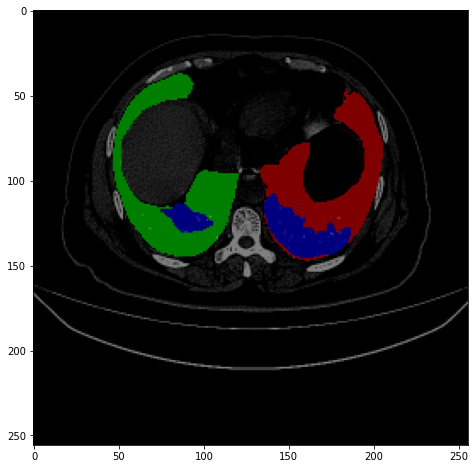

In [184]:
img_id = 100
plt.figure(figsize=(8,8))
label = torchvision.transforms.ToTensor()(dataset[img_id][1].numpy()).permute(1,2,0).unsqueeze(dim=0)
plt.imshow(dataset[img_id][0].permute(1,2,0).numpy(), cmap='bone')
plt.imshow(label.squeeze().permute(1,2,0).detach().numpy(), alpha=0.5, cmap='Reds')

In [1]:
model(inn).shape

NameError: name 'model' is not defined

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


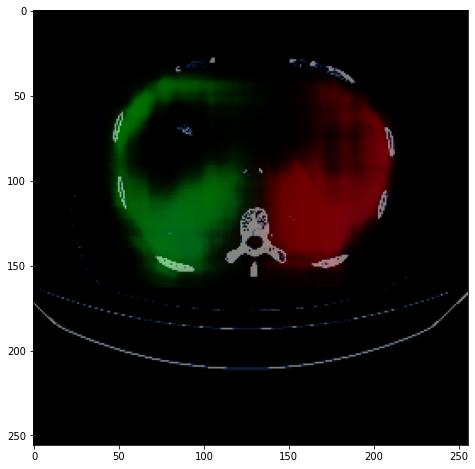

In [185]:
img_id = 100
plt.figure(figsize=(8,8))
inn = torchvision.transforms.ToTensor()(dataset[img_id][0].numpy()).permute(1,2,0)
inn = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(inn).unsqueeze(dim=0)
plt.imshow(inn.squeeze().permute(1,2,0).detach().numpy(), cmap='bone')
plt.imshow(model(inn).squeeze().permute(1,2,0).detach().numpy(), alpha=0.5, cmap='Reds')